In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pio.templates.default = "simple_white"

df = pd.read_csv('Subscriptions.csv')

df.head()


,Time Period,Subscribers
0,01/04/2013,34240000
1,01/07/2013,35640000
2,01/10/2013,38010000
3,01/01/2014,41430000
4,01/04/2014,46130000


In [19]:
df['Time_Period'] = pd.to_datetime(df['Time Period'], format='%d/%m/%Y')

fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=df['Time_Period'],
                          y=df['Subscribers'],
                          mode='lines+markers',
                          line=dict(color='darkblue', width=2),
                          name='Subscribers'))

fig1.update_layout(title=' Subscription Growth Over Time',
                   xaxis_title='Time',
                   yaxis_title='Number of Subscriber')

fig1.show()


The growth of Netflix subscribers shows no seasonality, making ARIMA a suitable forecasting technique.

In [20]:
df['Quarterly_Growth'] = df['Subscribers'].pct_change() * 100

df['Color'] = np.where(df['Quarterly_Growth'] > 0, 'forestgreen', 'orangered')

fig2 = go.Figure()
fig2.add_trace(go.Bar(x=df['Time_Period'],
                      y=df['Quarterly_Growth'],
                      marker=dict(color=df['Color']),
                      name='Quarterly Growth'))

fig2.update_layout(title='Quarterly Subscription Growth Rate',
                   xaxis_title='Time',
                   yaxis_title='Growth Rate (%)',
                   template='ggplot2')

fig2.show()


In [21]:
df['Year'] = df['Time_Period'].dt.year

df['Yearly_Growth'] = df.groupby('Year')['Subscribers'].pct_change().fillna(0) * 100

df['Yearly_Color'] = np.where(df['Yearly_Growth'] > 0, 'lightblue', 'red')


In [22]:
fig3 = go.Figure()
fig3.add_trace(go.Bar(x=df['Year'],
                      y=df['Yearly_Growth'],
                      marker=dict(color=df['Yearly_Color']),
                      name='Yearly Growth'))

fig3.update_layout(title='Yearly Subscription Growth Rate',
                   xaxis_title='Year',
                   yaxis_title='Yearly Growth Rate (%)',
                   template='plotly_white')

fig3.show()

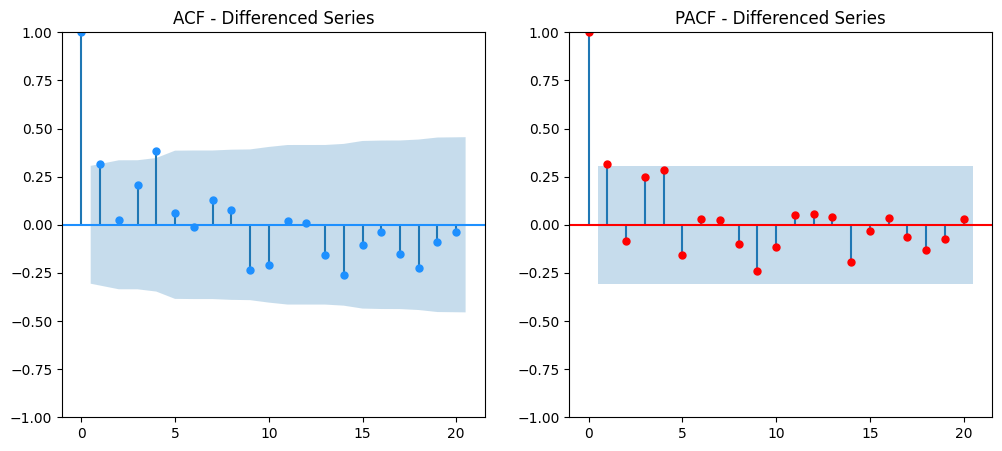

In [23]:
subscribers_series = df.set_index('Time_Period')['Subscribers']

diff_subscribers = subscribers_series.diff().dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(diff_subscribers, ax=axes[0], lags=20, color='dodgerblue')
axes[0].set_title('ACF - Differenced Series')

plot_pacf(diff_subscribers, ax=axes[1], lags=20, color='red')
axes[1].set_title('PACF - Differenced Series')

plt.show()


- We first calculated the differenced time series, removed NaN values, and then plotted ACF and PACF.
- ACF and PACF plots help identify the AR and MA components (p and q) for ARIMA.
- From the plots:
- ACF cuts off at lag 1 → q = 1
- PACF cuts off at lag 1 → p = 1
- With a linear trend in growth, we set d = 1 to make the time series stationary.
- ARIMA can then forecast future subscription counts based on the stationary series.

In [24]:
arima_model = ARIMA(subscribers_series, order=(1, 1, 1))
arima_fit = arima_model.fit()

print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            Subscribers   No. Observations:                   42
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -672.993
Date:                Sat, 05 Oct 2024   AIC                           1351.986
Time:                        19:57:58   BIC                           1357.127
Sample:                    04-01-2013   HQIC                          1353.858
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.012     80.765      0.000       0.975       1.024
ma.L1         -0.9908      0.221     -4.476      0.000      -1.425      -0.557
sigma2      1.187e+13   1.57e-14   7.57e+26      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



In [25]:

future_steps = 5
forecast_values = arima_fit.predict(len(subscribers_series),
                                    len(subscribers_series) + future_steps - 1)
forecast_values = forecast_values.astype(int)

forecast_df = pd.DataFrame({'Actual': subscribers_series, 'Forecast': forecast_values})

fig4 = go.Figure()

fig4.add_trace(go.Scatter(x=forecast_df.index,
                          y=forecast_df['Forecast'],
                          mode='lines',
                          line=dict(color='firebrick', dash='dash'),
                          name='Forecasted Subscribers'))

fig4.add_trace(go.Scatter(x=forecast_df.index,
                          y=forecast_df['Actual'],
                          mode='lines',
                          line=dict(color='navy'),
                          name='Actual Subscribers'))

fig4.update_layout(title='Actual vs Forecasted Subscribers',
                   xaxis_title='Time Period',
                   yaxis_title='Subscribers',
                   legend=dict(x=0.05, y=0.95))

fig4.show()
